# Previsão de preços de um Airbnb em Washington DC

Analisando um dataframe com as diversas características levadas em conta para o listing de uma propriedade para aluguel no site Airbnb, o projeto teve como intúito principal a utilização do machine learning para predizer o preço de uma propriedade qualquer na cidade de Washington com base em precedentes estudados.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import os 
import csv
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

Como filtro inicial para decidir quais as características relevantes para previsão do preço, buscamos nos ater ás características comumente expostas ao usuário no listing, para evitar grandes faltas de informações e consequentemente redução excessiva da base de dados a ser analizada.

In [5]:
#Trazendo os dados para o python
data = pd.read_excel('listings.xlsx')
df = data.loc[(data.state=='DC')&(data.city=='Washington')]
dataframe = data.loc[(data.state=='DC')&(data.city=='Washington')]

In [6]:
#Selecionando somente as colunas que queremos trabalhar com e tirando os sinais de moedas 
colunas = ["latitude", "longitude", "property_type","bathrooms", "bedrooms", "beds", "price","extra_people","minimum_nights", "review_scores_rating","cancellation_policy"]
df = df.loc[:,colunas]

df.price = df.price.str.replace('$', '')
df.price = df.price.str.replace(',', '')
df.extra_people = df.extra_people.str.replace('$', '')


df['price']=df['price'].astype(float)
df['extra_people']= df['extra_people'].astype(float)
df = df.dropna()





## Correlações 

Para a análise exploratória das variáveis quantitativas buscamos estabelecer o grau de correlação de cada uma delas não só com o preço mas entre umas as outras, visto que variáveis com correlação muito grande entre si devem também passar por adaptações visando a escolha de apenas uma, ou criação de uma nova, optimizando o resultado final.

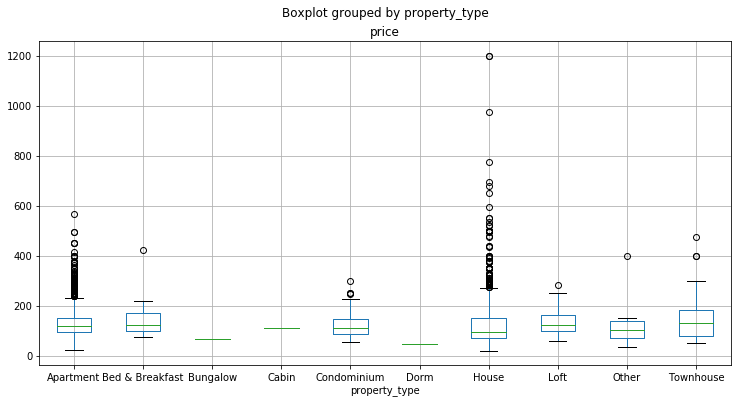

In [7]:
#Analisando a variavel quali Propery type e vendo se vale a pena adicionar ela ao nosso modelo

plt.rcParams['figure.figsize'] = (12,6)
df.boxplot(column=['price'], by='property_type');

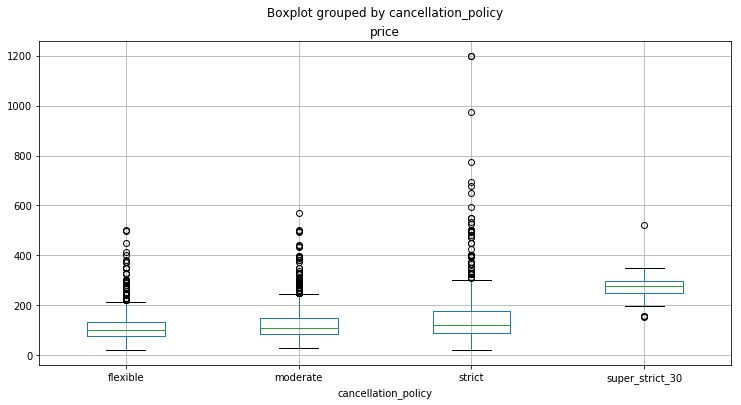

In [8]:
plt.rcParams['figure.figsize'] = (12,6)
df.boxplot(column=['price'], by='cancellation_policy');

A análise das variáveis qualitativas não apresentou grandes problemas, mas a evidência de um número relativamente grande de outliers foi evidente ao plota-los.

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Correlacao latitude vs price : -0.11977850029420414
Correlacao longitude vs price : -0.13265110792733373
Correlacao bathrooms vs price : 0.5263197092853233
Correlacao bedrooms vs price : 0.6104477984168931
Correlacao beds vs price : 0.566826558048037
Correlacao extra_people vs price : 0.1633593478911218
Correlacao minimum_nights vs price : 0.034239469945253315
Correlacao review_scores_rating vs price : 0.051161156394228885


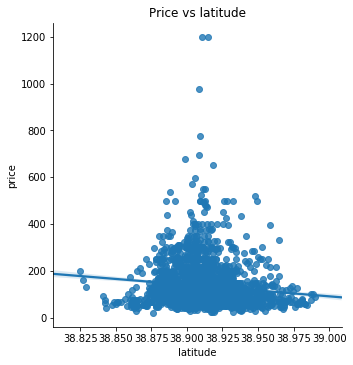

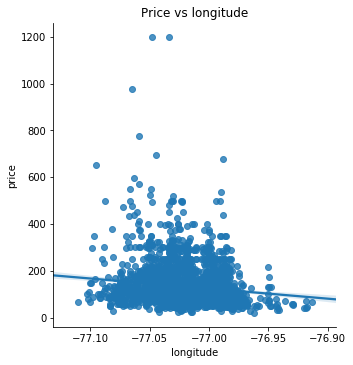

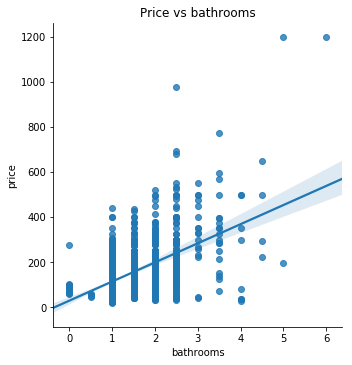

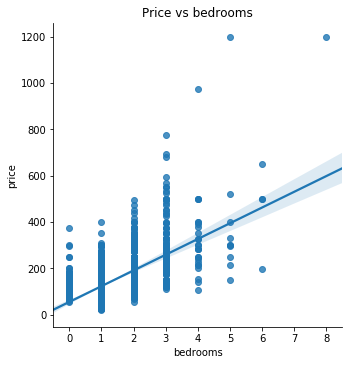

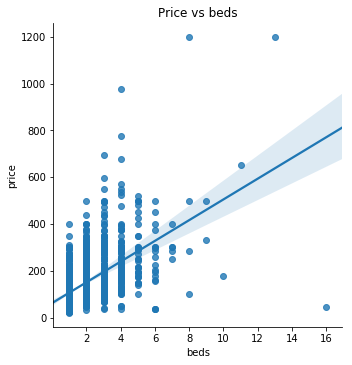

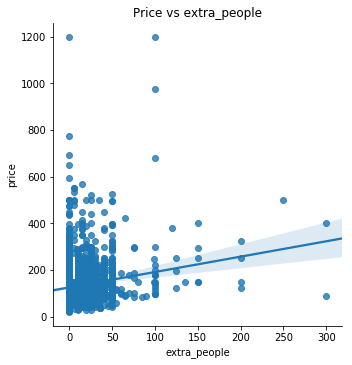

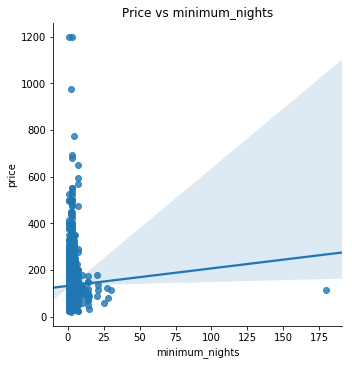

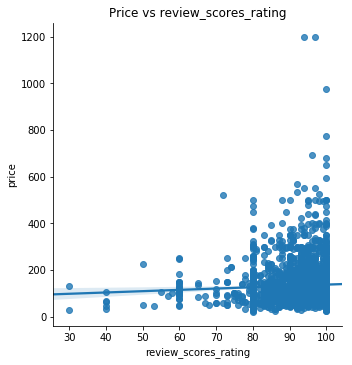

In [9]:
#criando uma funcao
colunas_quant= [ "latitude", "longitude","bathrooms", "bedrooms", "beds","extra_people","minimum_nights", "review_scores_rating"]

def funcao_corr(lista):
    for x in colunas_quant:
        sns.lmplot(x = x, y = 'price', data = df)
        plt.title('Price vs {0}'.format(x))
        print('Correlacao {0} vs price : {1}'.format(x,df.price.corr(df[x])))
        
        
funcao_corr(colunas_quant)
        
        

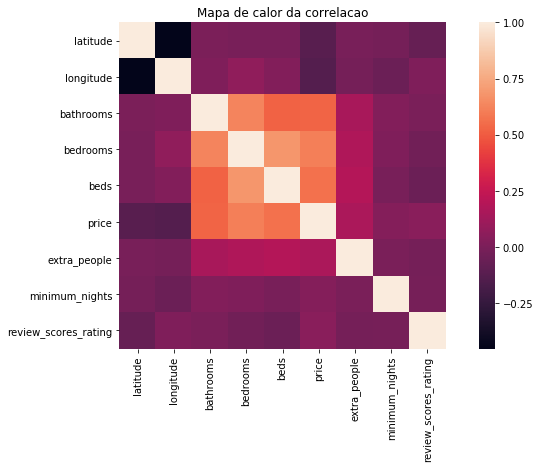

In [10]:
matrix = df.corr()
sns.heatmap(matrix, square = True);
plt.title('Mapa de calor da correlacao');

A partir da análise dos gráficos individuais das variáveis quantitativas ficou claro que não seria ideal o método de regressão linear para a previsão em questão, visto que havia uma defasagem muito grande da linha de tendência na maioria dos gráficos, tal observação resulta na escolha do método do random forest regression como forma ideal de análise destes dados, como pode ser observado a seguir.

# Random Forest Regression

A partir dos resultados anteriormente observados optamos pelo uso do método de Random forest regression para análise dos dados, método o qual gera um determinado número de árvores de possibilidades com ordens aleatórias de aplicação dos atributos visando prever o valor com base nos precedentes fornecidos na base de treinamento com características similares.

## 1a regressão

A primeira iteração da regressão foi efetuada utilizando apenas as características qualitativas observadas.

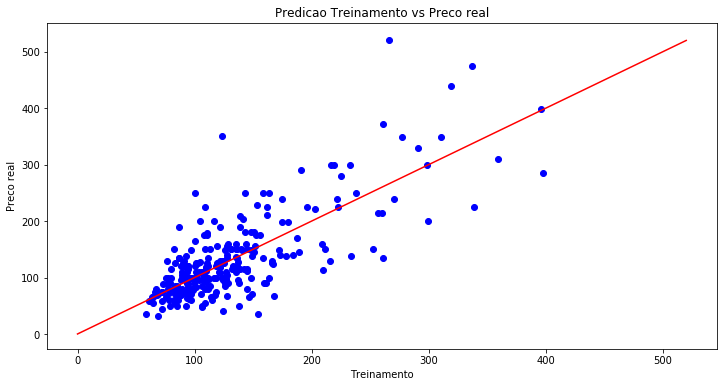

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

#Implementando o modelo de regressao random forest
variaveis = []

for x in colunas_quant:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df[colunas_quant], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 50)

regr.fit(X_train, y_train)

predicao1 = regr.predict(X_test)

y1 = np.max(y_test)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao1,y_test, c='b')
plt.title('Predicao Treinamento vs Preco real')
plt.ylabel('Preco real')
plt.xlabel('Treinamento')
plt.show()

In [12]:

print('O erro absoluto médio do df Teste é de: {0} USD'.format(mean_absolute_error(y_test,predicao1)))
print('O erro médio quadrático do df Teste é de: {0} USD'.format(mean_squared_log_error(y_test,predicao1)))

O erro absoluto médio do df Teste é de: 33.6328 USD
O erro médio quadrático do df Teste é de: 0.11355450632156817 USD


## 2a regressão -*óptima*

A segunda regressão consistiu na conversão dos atributos qualitativos a serem analisados em "quantitativos" por meio da criação de Dummies para que estes valores possam ser compreendidos pelo Random Forest Regressor.

In [13]:
colunas_t = []

dummies = df['property_type'].str.get_dummies(" ")
dummies2 = df['cancellation_policy'].str.get_dummies(" ")
df2 = pd.concat([df, dummies], axis=1, sort=False)
df3 = pd.concat([df2, dummies2], axis=1, sort=False)

for y in df3.columns:
    if y!= '&' and y!='property_type'and y!='cancellation_policy'and y!='price':
        colunas_t.append(y)
        
colunas_t

['latitude',
 'longitude',
 'bathrooms',
 'bedrooms',
 'beds',
 'extra_people',
 'minimum_nights',
 'review_scores_rating',
 'Apartment',
 'Bed',
 'Breakfast',
 'Bungalow',
 'Cabin',
 'Condominium',
 'Dorm',
 'House',
 'Loft',
 'Other',
 'Townhouse',
 'flexible',
 'moderate',
 'strict',
 'super_strict_30']

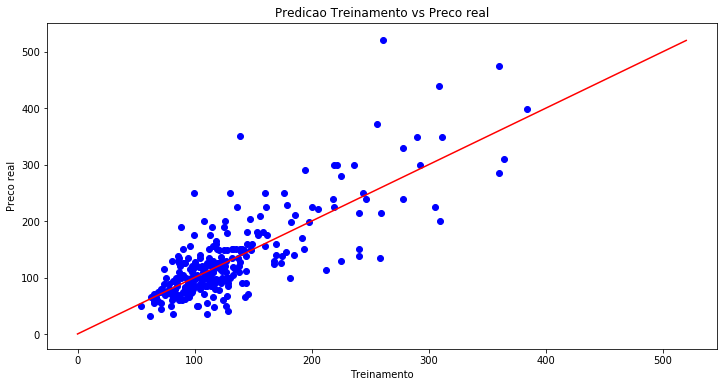

In [14]:

variaveis = []

for x in df3.columns:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df3[colunas_t], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 40)

regr.fit(X_train, y_train)

predicao2= regr.predict(X_test)

y1 = np.max(y_test)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao2,y_test, c='b')
plt.title('Predicao Treinamento vs Preco real')
plt.ylabel('Preco real')
plt.xlabel('Treinamento')
plt.show()

In [19]:
print('O erro absoluto médio do df Teste é de: {0} USD'.format(mean_absolute_error(y_test,predicao2)))
print('O erro médio quadrático do df Teste é de: {0} USD'.format(mean_squared_log_error(y_test,predicao2)))

O erro absoluto médio do df Teste é de: 31.195345454545453 USD
O erro médio quadrático do df Teste é de: 0.10014547878200969 USD


## 3a regressão

Com o intuito de optimizar o resultado obtido, buscamos a remoção de atributos que não apresentassem grande relevância para o resultado assim a retirada dos mesmos seria benéfica. 

Apesar de tentarmos a remoção de variáveis, buscando maior precisão do preditor uma vez que feita a primeira remoção, esta sendo a da característica 'review_scores_rating', não houveram resultados positivos ao efetuar a retirada de uma segunda, assim podendo-se dizer que chegamos à precisão máxima para tais características (com a retirada da característica de menor relevância após a retirada da primeira, foi observado um decréscimo na precisão da previsão).
    

In [16]:
colunasj=[]
for x in colunas_t:
    if x!='review_scores_rating':
        colunasj.append(x)

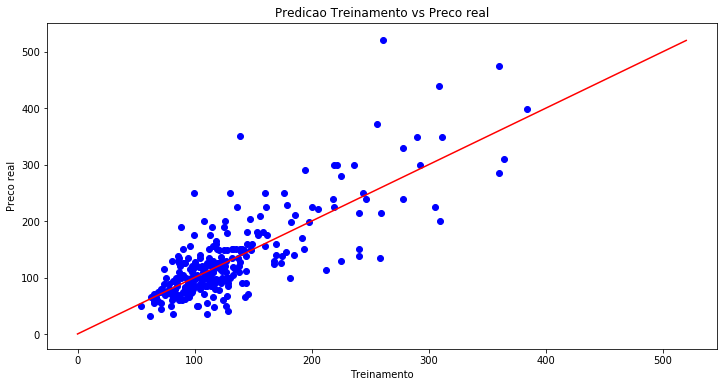

In [17]:

variaveis = []


for x in df3.columns:
    if x != 'price':
        variaveis.append(x)

        
X_train, X_test, y_train, y_test = train_test_split(df3[colunasj], df['price'], test_size=0.1, random_state=0)

regr = RandomForestRegressor(bootstrap = True, max_features = 'auto', n_estimators = 100, max_depth = 40)

regr.fit(X_train, y_train)

predicao3= regr.predict(X_test)

y1 = np.max(y_test)
linha_adequada = np.linspace(0,y1, 10)
plt.plot(linha_adequada, linha_adequada, c = 'r')

plt.scatter(predicao2,y_test, c='b')
plt.title('Predicao Treinamento vs Preco real')
plt.ylabel('Preco real')
plt.xlabel('Treinamento')
plt.show()

In [20]:
print('O erro absoluto médio do df Teste é de: {0} USD'.format(mean_absolute_error(y_test,predicao3)))
print('O erro médio quadrático do df Teste é de: {0} USD'.format(mean_squared_log_error(y_test,predicao3)))

O erro absoluto médio do df Teste é de: 31.53225454545455 USD
O erro médio quadrático do df Teste é de: 0.10332273030121752 USD


## Conclusão

O preditor teve sucesso considerável em sua última iteração, com uma taxa de erro média por volta de 31 USD , o último ajuste referente à remoção de uma característica irrelevante não foi significativo para o caso em questão, visto que as características selecionadas em maioria apresentam uma grande contribuição à precisão final, apesar da remoção da característica efetuada não ter representado grandes mudanças no resultado final.